In [364]:
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import surprise

from surprise import SVD, KNNBaseline, KNNBasic, KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



import matplotlib.pyplot as plt

In [342]:
df = pd.read_csv("steamWithIds-200k.csv")
df

,Unnamed: 0,playerId,gameTitle,playerGameStatus,time,zero,gameId
0,0,151603712,The Elder Scrolls V: Skyrim,purchase,1.0,0,72850.0
1,1,151603712,The Elder Scrolls V: Skyrim,play,273.0,0,72850.0
2,2,151603712,Fallout 4,purchase,1.0,0,377160.0
3,3,151603712,Fallout 4,play,87.0,0,377160.0
4,6,151603712,Fallout: New Vegas,purchase,1.0,0,22380.0
...,...,...,...,...,...,...,...
142309,199995,128470551,Titan Souls,play,1.5,0,297130.0
142310,199996,128470551,Grand Theft Auto Vice City,purchase,1.0,0,12110.0
142311,199997,128470551,Grand Theft Auto Vice City,play,1.5,0,12110.0
142312,199998,128470551,RUSH,purchase,1.0,0,38720.0


In [343]:
df_purchase = df.loc[(df['playerGameStatus']=='purchase')]
#df_purchase.to_csv("steamPurchased-200k.csv")

In [344]:
play = df.loc[(df['playerGameStatus']=='play')]
#play.to_csv("steamPlayed-200k.csv"

In [345]:
play.drop_duplicates(inplace=True)
#swapping columns
play=play[['playerId','gameId','time']] 
play.columns = ['playerId','gameId','time']


#remove all pairs that have been played less than 10 hours
play[play['time'] > 10]


train,test = train_test_split(play, test_size=0.3 )


<ipython-input-345-de800457339d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play.drop_duplicates(inplace=True)


In [346]:
# baseline estimation (naive)
# Each user will spend the averge amount of time playing the game (doesnt look at users of games)
# Group each game and average the time spent playing.
baseline_y_pred = pd.DataFrame(train.groupby('gameId')['time'].mean())

In [347]:
y_pred_and_y_true = pd.merge(baseline_y_pred, test, on='gameId')
baseline_y_pred_vs_y_true = y_pred_and_y_true.rename(columns={"time": "Predicted rating"})

baseline_y_pred_vs_y_true

,gameId,time_x,playerId,time_y
0,10.0,242.071007,53258793,1511.0
1,10.0,242.071007,26461910,329.0
2,10.0,242.071007,20366600,0.4
3,10.0,242.071007,861238,0.6
4,10.0,242.071007,64319625,0.4
...,...,...,...,...
15847,997530.0,8.340909,33013552,0.3
15848,997530.0,8.340909,58905429,0.9
15849,997530.0,8.340909,45411694,49.0
15850,997530.0,8.340909,117531196,5.2


In [348]:
baseline = math.sqrt(mean_squared_error(baseline_y_pred_vs_y_true["time_x"], 
                                                       baseline_y_pred_vs_y_true["time_y"]))
# calculating RMSE for the baseline model
print("RMSE baseline model: ", baseline)

RMSE baseline model:  222.51753415634133


In [349]:
# when importing from a DF, you only need to specify the scale of the ratings.
max_value = play["time"].max()
print(max_value)

min_value = play["time"].min()
print(min_value)


reader = surprise.Reader(rating_scale=(1,5))



#into surprise:
data = surprise.Dataset.load_from_df(train,reader)
holdout = surprise.Dataset.load_from_df(test,reader)

11754.0
0.1


In [350]:
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True) # split data into folds. 
sim_options = sim_options = {'name': 'cosine',
               'user_based': False}

rmseKNN = []
rmseSVD = []

In [351]:
%%capture

collabKNN = surprise.KNNBasic(k=50,sim_options=sim_options) #try removing sim_options. You'll find memory errors. 

for trainset, testset in kSplit.split(data): #iterate through the folds.
    collabKNN.fit(trainset)
    predictionsKNN = collabKNN.test(testset)
    rmseKNN.append(surprise.accuracy.rmse(predictionsKNN,verbose=True))#get root means squared error

In [352]:
print("The RMSE for KNN over 10 folds: " +str(sum(rmseKNN)/len(rmseKNN)))

The RMSE for KNN over 10 folds: 261.6790538956742


In [353]:
funkSVD = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)

In [354]:

#for trainset, testset in kSplit.split(data): #iterate through the folds.
    

In [355]:
%%capture

min_error = 1
for trainset, testset in kSplit.split(data): #iterate through the folds.
    funkSVD.fit(trainset)
    predictionsSVD = funkSVD.test(testset)
    rmseSVD.append(surprise.accuracy.rmse(predictionsSVD,verbose=True))#get root means squared error

In [356]:
print("The RMSE for KNN over 10 folds: " +str(sum(rmseSVD)/len(rmseSVD)))

The RMSE for KNN over 10 folds: 264.28647939490946


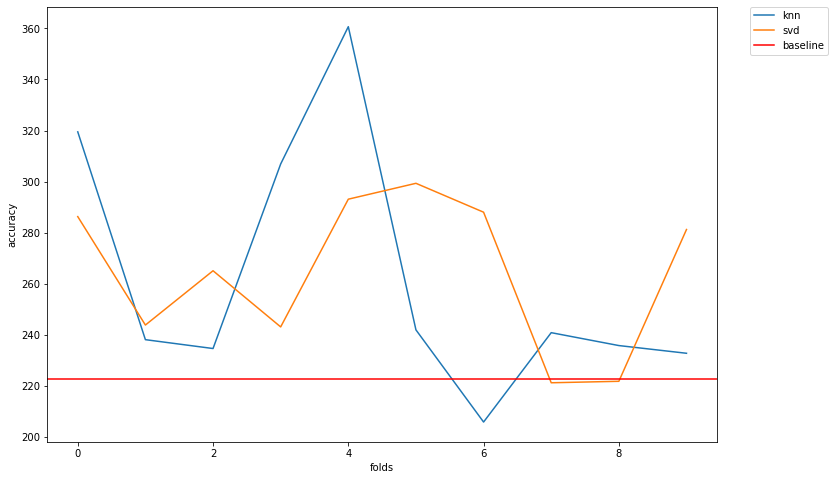

In [357]:
plt.figure(figsize=(12, 8)) 
plt.plot(rmseKNN,label='knn')
plt.plot(rmseSVD,label='svd')
plt.axhline(y=baseline, color='r', linestyle='-', label = 'baseline')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [179]:
## Ddoes not perform much better than random because the matrix is very sparse. Meaning lots of users and lots
# of items but few matches
# Therefore need content based

In [180]:
game_info = pd.read_csv("gameInfo/steam.csv")
#game_info.columns
game_info = pd.concat([game_info, game_info['steamspy_tags'].str.split(';', expand=True)], axis=1).drop(columns=['platforms', 'required_age', 'categories', 
                                                                                                     'genres', 'steamspy_tags', 'achievements', 'positive_ratings',
                                                                                                    'negative_ratings', 'average_playtime', 'median_playtime', 'owners',
                                                                                                    'release_date','english', 'price'])

game_info = game_info.dropna()

game_info['combined']= list(filter(None,game_info[[0,1,2]].values.tolist()))

game_info = game_info.drop(columns=[0,1,2])
game_info[0:50]

,appid,name,developer,publisher,combined
0,10,Counter-Strike,Valve,Valve,"[Action, FPS, Multiplayer]"
1,20,Team Fortress Classic,Valve,Valve,"[Action, FPS, Multiplayer]"
2,30,Day of Defeat,Valve,Valve,"[FPS, World War II, Multiplayer]"
3,40,Deathmatch Classic,Valve,Valve,"[Action, FPS, Multiplayer]"
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,"[FPS, Action, Sci-fi]"
5,60,Ricochet,Valve,Valve,"[Action, FPS, Multiplayer]"
6,70,Half-Life,Valve,Valve,"[FPS, Classic, Action]"
7,80,Counter-Strike: Condition Zero,Valve,Valve,"[Action, FPS, Multiplayer]"
8,130,Half-Life: Blue Shift,Gearbox Software,Valve,"[FPS, Action, Sci-fi]"
9,220,Half-Life 2,Valve,Valve,"[FPS, Action, Sci-fi]"


In [182]:
mlb = MultiLabelBinarizer()

genres = pd.DataFrame(mlb.fit_transform(game_info["combined"]),columns=mlb.classes_, index=game_info.index)


In [183]:
genres

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [369]:
mergedDf = game_info.merge(genres, left_index=True, right_index=True)
mergedDf = mergedDf.drop(columns=['developer', 'publisher', 'combined'])

In [370]:
cosine_sim = linear_kernel(mergedDf.drop(columns=['appid', 'name']), mergedDf.drop(columns=['appid', 'name']))


In [371]:
cosine_sim.shape


(24410, 24410)

In [373]:
cosine_sim[2]


array([2., 2., 3., ..., 0., 0., 0.])